In [1]:
%load_ext autoreload
%autoreload 1

import json
import os
import pickle
import time
import timeit

import numpy as np

os.environ["DGLBACKEND"] = "pytorch"

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import from_networkx, edge_subgraph
from dgl.nn.pytorch import EdgeWeightNorm
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.utils import class_weight

from src.calculate_FPR_FNR import calculate_FPR_FNR
from src.dataset.dataset_info import datasets
import src.models as models
# from src.models import EGAT, EGCN, EGRAPHSAGE, Model
from src.plot_confusion_matrix import plot_confusion_matrix

%aimport src.models

num_epochs = 10
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001

In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

with_centralities = False

node_features = False
node_features_version = 2

validate = True
validate_epoch = 1

using_masking = False
masked_class = 2

multi_class = True

# dataset properties
use_port_in_address = False
generated_ips = False

graph_type = "flow"
# graph_type = "window"
# graph_type = "line"

window_size= 2000

sort_timestamp = False

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\cic_ids_2017_5_percent'

In [3]:
g_type = ""
if graph_type == "flow":
    g_type = "flow"
elif graph_type == "line":
    g_type = f"line_graph_{window_size}"
elif graph_type == "window":
    g_type = f"window_graph_{window_size}"
    
if multi_class:
    g_type += "__multi_class"
    
# if k_fold:
#     g_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    g_type += "__ports"
    
if generated_ips:
    g_type += "__generated_ips"
    
if sort_timestamp:
    g_type += "__sorted"
else:
    g_type += "__unsorted"
    
graphs_folder = os.path.join(dataset_folder, g_type)
graphs_folder

'datasets\\cic_ids_2017_5_percent\\flow__multi_class__unsorted'

In [4]:
number_neighbors = [25, 10]
# number_neighbors = None
num_layers=2
ndim_out = [128, 128]
aggregation="mean"
activation=F.relu
dropout=0.2

my_models = [
    # Model("e_gcn", models.EGCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False, norm=True),
    # Model("e_gcn_res", models.EGCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True, norm=True),
    models.Model("e_graph_sage", models.EGRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False, aggregation=aggregation, num_neighbors=number_neighbors),
    # Model("e_graph_sage_res", models.EGRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True, aggregation=aggregation, number_neighbors=number_neighbors),
    # Model("e_gat", models.EGAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=False),
    # Model("e_gat_res", models.EGAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, residual=True),
]

In [5]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": number_neighbors,
    "with_centralities": with_centralities,
    "node_features": node_features,
    "node_features_version": node_features_version,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}
results_final["val_accuracy"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

for m in my_models:
    results_final[m.model_name] = {}

results_final

{'name': 'cic_ids_2017_5_percent',
 'configuration': {'num_epochs': 10,
  'multi_class': True,
  'batch_size': 128,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'node_features': False,
  'node_features_version': 2},
 'accuracy': {},
 'time_elapsed': {},
 'val_accuracy': {},
 'val_precision': {},
 'val_recall': {},
 'val_f1': {},
 'val_FPR': {},
 'val_FNR': {},
 'e_graph_sage': {}}

In [6]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250106-101207'

In [7]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [8]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('BENIGN'),
  np.str_('Bot'),
  np.str_('DDoS'),
  np.str_('DoS GoldenEye'),
  np.str_('DoS Hulk'),
  np.str_('DoS Slowhttptest'),
  np.str_('DoS slowloris'),
  np.str_('FTP-Patator'),
  np.str_('Infiltration'),
  np.str_('PortScan'),
  np.str_('SSH-Patator'),
  np.str_('Web Attack � Brute Force'),
  np.str_('Web Attack � Sql Injection'),
  np.str_('Web Attack � XSS')],
 14)

In [9]:
with open(os.path.join(graphs_folder, "training_graph.pkl"), "rb") as f:
    G = pickle.load(f)

In [10]:
with open(os.path.join(graphs_folder, "validation_graph.pkl"), "rb") as f:
    G_val = pickle.load(f)

In [11]:
with open(os.path.join(graphs_folder, "testing_graph.pkl"), "rb") as f:
    G_test = pickle.load(f)

In [12]:
edge_attributes = edge_attrs = ['h', dataset.label_col, dataset.class_num_col]

if node_features:
    G = from_networkx(G, edge_attrs=edge_attributes, node_attrs=["n_feats"])
    G_val = from_networkx(G_val, edge_attrs=edge_attributes, node_attrs=["n_feats"])  
    G_test = from_networkx(G_test, edge_attrs=edge_attributes, node_attrs=["n_feats"])  
else:
    G = from_networkx(G,  edge_attrs=edge_attributes)
    G_val = from_networkx(G_val,  edge_attrs=edge_attributes)
    G_test = from_networkx(G_test,  edge_attrs=edge_attributes)

In [13]:
num_features = G.edata['h'].shape[1]
num_features

31

In [14]:
if using_masking:
    # Create masks for edges
    training_mask = G.edata[dataset.class_num_col] != masked_class  # Include all edges except class 3
    val_mask = G_val.edata[dataset.class_num_col] == masked_class    # Include only edges of class 3 (or other validation logic)
    test_mask = G_test.edata[dataset.class_num_col] == masked_class   # Include only edges of class 3
    
    G = edge_subgraph(G, training_mask)
    G_val = edge_subgraph(G_val, val_mask)
    G_test = edge_subgraph(G_test, test_mask)


In [15]:
if node_features:
    # G.ndata["h"] = th.cat([G.ndata["n_feats"], th.ones(G.num_nodes(), num_features)], dim=1)
    G.ndata["h"] = G.ndata["n_feats"]
else:
    G.ndata['h'] = th.ones(G.num_nodes(), num_features)  # noqa: F821
    
ndim_in = G.ndata["h"].shape[-1]

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, ndim_in))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
# G.edata['train_mask'] = training_mask

In [16]:
if multi_class:
    class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(
                                                    G.edata[dataset.class_num_col].cpu().numpy()),
                                                y=G.edata[dataset.class_num_col].cpu().numpy())
else:
    class_weights = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(
                                                        G.edata[dataset.label_col].cpu().numpy()),
                                                    y=G.edata[dataset.label_col].cpu().numpy())

In [17]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [18]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [19]:
if multi_class:
    val_labels = G_val.edata[dataset.class_num_col]
else:
    val_labels = G_val.edata[dataset.label_col]

if node_features:
    G_val.ndata["feature"] = th.cat([G_val.ndata["n_feats"], th.ones(G_val.num_nodes(), num_features)], dim=1)
else:
    G_val.ndata['feature'] = th.ones(G_val.num_nodes(),  num_features)

ndim_in = G_val.ndata["feature"].shape[-1]

G_val.ndata['feature'] = th.ones(G_val.num_nodes(),  num_features)

G_val.edata['val_mask'] = th.ones(len(G_val.edata['h']), dtype=th.bool)
# G_val.edata['val_mask'] = val_mask

In [20]:
G_val.ndata['feature'] = th.reshape(G_val.ndata['feature'], (G_val.ndata['feature'].shape[0], 1, G_val.ndata['feature'].shape[1]))
G_val.edata['h'] = th.reshape(G_val.edata['h'], (G_val.edata['h'].shape[0], 1, G_val.edata['h'].shape[1]))

In [21]:
def test_gnn(model:models.Model, graph, actual_labels):
    start_time = timeit.default_timer()

    if model.norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    
    test_pred = model.trained_model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual_labels)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual_labels]
        
    if multi_class:
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [22]:
def train_gnn(model: models.Model, Graph):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    if multi_class:
        edge_label = Graph.edata[dataset.class_num_col]
    else:
        edge_label = Graph.edata[dataset.label_col]
        
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if model.norm:
        edge_weight = th.ones(Graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(Graph, edge_weight)
        Graph.edata['norm_weight'] = norm_edge_weight

    if model.model_class == models.EGRAPHSAGE:
        model.trained_model = model.model_class(ndim_in, num_features, model.ndim_out, num_layers=model.num_layers, activation=model.activation, aggregation=model.aggregation,
                            dropout=model.dropout, num_neighbors=model.num_neighbors, residual=model.residual, num_class=num_classes)
    else:
        model.trained_model = model.model_class(ndim_in, num_features, model.ndim_out, model.activation,
                            dropout=model.dropout, residual=model.residual, num_class=num_classes)

    opt = th.optim.Adam(model.trained_model.parameters(), lr = learning_rate)

    val_acc = []
    val_precision = []
    val_recall = []
    val_f1 = []
    val_FPR = []
    val_FNR = []
    for epoch in range(1, num_epochs):
        pred = model.trained_model(Graph, node_features, edge_features)
        loss = criterion(pred[train_mask], edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch == 1:
            print(f"Edge label shape: {edge_label.shape}")
            print(f"Edge label unique values: {th.unique(edge_label)}")
            print(f"Pred shape: {pred.shape}")
            
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(
            pred[train_mask], edge_label[train_mask]))
        if validate and epoch % validate_epoch == 0:
            actual, test_pred, elapsed = test_gnn(model, G_val, val_labels)
            cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
            val_acc.append(cr["accuracy"])
            val_precision.append(cr['weighted avg']['precision'])
            val_recall.append(cr['weighted avg']['recall'])
            val_f1.append(cr['weighted avg']['f1-score'])

            cm = confusion_matrix(actual, test_pred, labels=labels)
            FPR, FNR = calculate_FPR_FNR(cm)
            val_FPR.append(FPR)
            val_FNR.append(FNR)
            print('Epoch:', epoch, "Validation acc:", cr["accuracy"])
            print("Time for validation: ", str(elapsed) + ' seconds')
    if validate:
        results_final["val_accuracy"][model.model_name] = val_acc
        results_final["val_precision"][model.model_name] = val_precision
        results_final["val_recall"][model.model_name] = val_recall
        results_final["val_f1"][model.model_name] = val_f1
        results_final["val_FPR"][model.model_name] = val_FPR
        results_final["val_FNR"][model.model_name] = val_FNR
    return model

### Training GNN models

In [23]:
# %autoreload

In [24]:
for m in my_models:
    train_gnn(m, G)

v2


Edge label shape: torch.Size([114416])
Edge label unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Pred shape: torch.Size([114416, 14])
Epoch: 1  Training acc: 0.0023073696065694094
Epoch: 1 Validation acc: 0.0036970030677259498
Time for validation:  0.161470300052315 seconds
Epoch: 2  Training acc: 0.0007341630407609046
Epoch: 2 Validation acc: 0.00259576811138205
Time for validation:  0.07866609981283545 seconds
Epoch: 3  Training acc: 0.004221437498927116
Epoch: 3 Validation acc: 0.01282152127743255
Time for validation:  0.3664122000336647 seconds
Epoch: 4  Training acc: 0.0018441476859152317
Epoch: 4 Validation acc: 0.04082435302446315
Time for validation:  0.08969100005924702 seconds
Epoch: 5  Training acc: 0.1301129162311554
Epoch: 5 Validation acc: 0.18815385825532918
Time for validation:  0.06807020003907382 seconds
Epoch: 6  Training acc: 0.12420465797185898
Epoch: 6 Validation acc: 0.06379296782820734
Time for validation:  0.053563700057566166 s

# Testing

In [25]:
if multi_class:
    test_labels = G_test.edata[dataset.class_num_col]
else:
    test_labels = G_test.edata[dataset.label_col]

if node_features:
    G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

ndim_in = G_test.ndata["feature"].shape[-1]

G_test.edata['test_mask'] = th.ones(len(G_test.edata['h']), dtype=th.bool)
# G_test.edata['test_mask'] = test_mask

In [26]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

### Testing GNN models

testing model: e_graph_sage


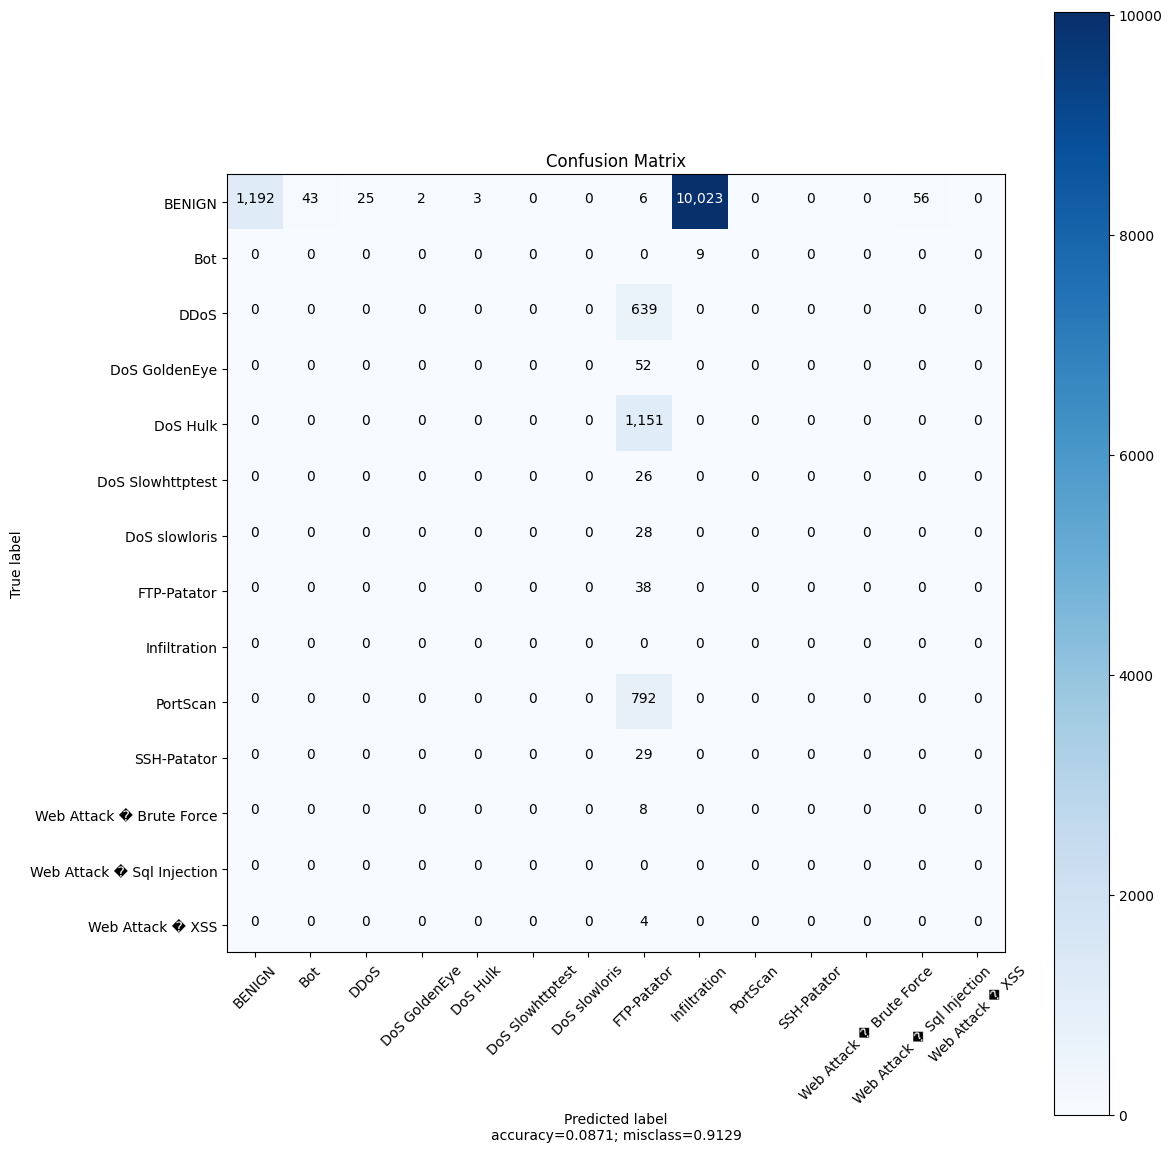

                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.1050    0.1901     11350
                       Bot     0.0000    0.0000    0.0000         9
                      DDoS     0.0000    0.0000    0.0000       639
             DoS GoldenEye     0.0000    0.0000    0.0000        52
                  DoS Hulk     0.0000    0.0000    0.0000      1151
          DoS Slowhttptest     0.0000    0.0000    0.0000        26
             DoS slowloris     0.0000    0.0000    0.0000        28
               FTP-Patator     0.0137    1.0000    0.0270        38
              Infiltration     0.0000    0.0000    0.0000         0
                  PortScan     0.0000    0.0000    0.0000       792
               SSH-Patator     0.0000    0.0000    0.0000        29
  Web Attack � Brute Force     0.0000    0.0000    0.0000         8
Web Attack � Sql Injection     0.0000    0.0000    0.0000         0
          Web Attack � XSS     0.0000    0.0000

In [27]:
for m in my_models:
    print("=======================")
    print(f"testing model: {m.model_name}")
    actual, test_pred, elapsed = test_gnn(m, G_test, test_labels)
    cm = confusion_matrix(actual, test_pred, labels=labels)
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    FPR, FNR = calculate_FPR_FNR(cm)
    
    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    results_final[m.model_name]["elapsed"] = elapsed
    results_final[m.model_name]["classification_report"] = cr
    results_final[m.model_name]["FPR"] = FPR
    results_final[m.model_name]["FNR"] = FNR
    results_final["accuracy"][m.model_name] = cr["accuracy"]
    results_final["time_elapsed"][m.model_name] = elapsed

    print(classification_report(actual, test_pred, digits=4, zero_division=0))

### Saving results

In [28]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)


filename = (folder_path + '/results.json')
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()